### Semantic features as word embeddings

In [1]:
import numpy as np
import os
import torch
import json
from tqdm import tqdm

### Semantic features

In [2]:
min_len_line = 5
N_SEMANTIC_FEATURES = 25
semantic_features = {}

def dump_mitchell_web_semantic_features(raw_file = os.path.join("data","mitchell_semantic_raw.txt")):
    with open(raw_file, "r") as datafile:
        lines = datafile.readlines()
        word = None

        for line in lines:

            # Skip empty
            if len(line) >= min_len_line:

                # New feature
                if "Features for" in line:

                    # Discard invalid ones (once fully parsed)
                    if word and len(semantic_features[word]['features']) < N_SEMANTIC_FEATURES: del semantic_features[word] 
                        
                    word = line.split("<a name=\"")[1].split("\"")[0]
                    semantic_features[word] = { "features": [], "values": []}

                elif word:
                    feature_name = line.split("(")[0]
                    val = float(line.split("(")[1].split(")")[0])
                    semantic_features[word]["features"].append(feature_name)
                    semantic_features[word]["values"].append(val)

    # Save to file
    with open(os.path.join('data', 'mitchell_semantic_features.json'), 'w') as fp:
        json.dump(semantic_features, fp)

    return semantic_features

In [3]:
semantic_features = dump_mitchell_web_semantic_features()

### fMRI data

In [4]:
def get_word_activations(path, skip_lines=0):
    """
        Returns dataset of fMRI word activations
        path            Path to .txt fMRI data vectors (continuous) from Cognival
        context_len     Words before the occurring one
        data            Returned dictionary with key ['word'] -> {'context', 'activations'}
    """
    data = {}
    with open(path, "r") as datafile:
        lines = datafile.readlines()[skip_lines:] # skip header
        for line in tqdm(lines):
            word = line.split(" ")[0]
            activations = np.array([float(x) for x in line.split(" ")[1:]])
            data[word] = {"activations": activations}
    return data

In [5]:
subject = 1
voxels = 1000

# Over all subjects
filename = os.path.join("data", "cognival", "fmri", "nouns", f"{voxels}-random-voxels", f"scaled_{voxels}_mitchell_targets_{subject}.txt")
fmriData = get_word_activations(filename, skip_lines = 1)

100%|██████████| 60/60 [00:00<00:00, 1477.16it/s]


### Predicting

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression

from tqdm import tqdm
from numpy import dot
from numpy.linalg import norm

def cosim(a, b):
    return dot(a, b)/(norm(a)*norm(b))

In [7]:
def compute_fold_accuracy(predictors, X_test, y_test, selected_voxels):

    p1 = np.array([predictor.predict([X_test[0]])[0] for predictor in predictors])[selected_voxels]
    p2 = np.array([predictor.predict([X_test[1]])[0] for predictor in predictors])[selected_voxels]
    i1, i2 = y_test[:, selected_voxels] # 0, 1

    # True positives
    tp1 = int(cosim(p1, i1) > cosim(p1, i2))
    tp2 = int(cosim(p2, i1) < cosim(p2, i2))

    return (tp1 + tp2) / 2

In [8]:
k_folds = 30
n_samples = len(semantic_features.keys())

assert n_samples % k_folds == 0, "Number of folds must divide the samples in equal parts. Choose a valid multiplier."

samples_per_fold = (n_samples // k_folds)
n_voxels = fmriData["bell"]["activations"].shape[0]
THRESHOLD = 0.2
accuracies = []
voxels_amounts = []

n_samples, samples_per_fold, n_voxels

(60, 2, 1000)

In [9]:
for i in tqdm(range(k_folds)):

    # Extracting filtered (most stable voxels) training set
    train_indices = np.array(list(range(samples_per_fold * i)) + list(range((samples_per_fold * (i+1)), n_samples)), dtype=np.int32)
    test_indices = np.array(list(range((samples_per_fold * i), samples_per_fold * (i + 1))), dtype=np.int32)

    # Building train set
    X = []
    Y = []

    for word in semantic_features.keys():
        if word in fmriData.keys():
            x = np.array(semantic_features[word]["values"])
            y = np.array(fmriData[word]["activations"])

            X.append(x)
            Y.append(y)

    X = np.array(X)
    Y = np.array(Y)

    # Train-test split
    X_train, X_test, y_train, y_test = X[train_indices], X[test_indices], Y[train_indices], Y[test_indices]
    
    # Normalization based on train data
    normalizer = StandardScaler()
    normalizer.fit(X_train)

    X_train = normalizer.transform(X_train)
    X_test = normalizer.transform(X_test)

    # Predicting & scoring
    predictors = [LinearRegression() for i in range(n_voxels)]
    scores = []

    # One predictor per voxel
    j = 0
    for model in predictors:
        model.fit(X_train, y_train[:, j])
        scores.append(model.score(X_test, y_test[:, j]))
        j += 1

    # Select voxels by R2 score and compute 2 words accuracy
    scores = np.array(scores)
    voxel_indices = np.where(scores > THRESHOLD)[0]
    
    voxels_amounts.append(voxel_indices.shape[0])
    accuracies.append(compute_fold_accuracy(predictors, X_test, y_test, voxel_indices))

np.mean(accuracies), np.mean(voxels_amounts)


100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


(0.9833333333333333, 91.26666666666667)

**Observation**

On average, around 100 voxels (10%) achieve a an acceptable R2 score and this subsets achieves 98% of accuracy in predicting distinguishable brain activity! Also: the higher the threshold, the smaller the subset and the higher the accuracy!
- Threshold: 0.7, mean accuracy: 1.0, voxels: 77
- Threshold: 0.2, mean accuracy: 0.98, voxels: 92
- Treshold: 0, mean accuracy: 0.98, voxels: 122

Test RDMs R^2:	PearsonRResult(statistic=0.13951911832313996, pvalue=4.3324706204712967e-16)


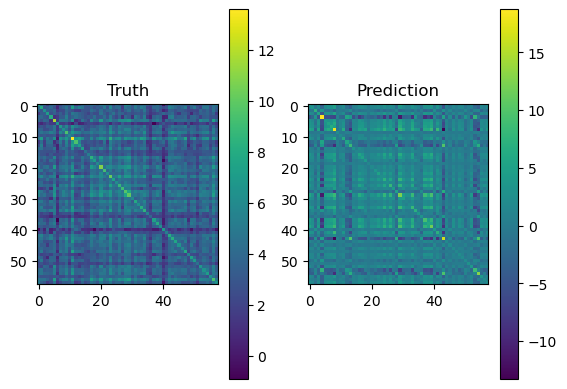

In [10]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def best_K_predict(X, indices, predictors):
    predictors = [predictors[idx] for idx in indices]
    y_hat = np.array([predictor.predict(X) for predictor in predictors]) # voxels, sample
    return y_hat.reshape(y_hat.shape[1], y_hat.shape[0]) # sample, voxels


y_hat = best_K_predict(X_train, voxel_indices, predictors)
y = y_train[:, voxel_indices]

RDM_hat = np.matmul(y_hat, np.matrix.transpose(y_hat))

RDM = np.matmul(y, np.matrix.transpose(y))

test_pearson = pearsonr(
    RDM_hat.flatten(),
    RDM.flatten()
)

print(f"Test RDMs R^2:\t{test_pearson}")

plt.subplot(121)
plt.title("Truth")
plt.imshow(RDM)
plt.colorbar()

plt.subplot(122)
plt.title("Prediction")
plt.imshow(RDM_hat)
plt.colorbar()

**Observation**

Here the the voxels from the last cross_val iteration have been selected. For these voxels, the object to object distance matrices have similar patterns.